C:\Users\Janith\AppData\Local\Temp\ipykernel_34960\2446768529.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\Janith\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6062 - val_loss: 0.4948
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3892 - val_loss: 0.3571
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2936 - val_loss: 0.2923
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2604 - val_loss: 0.2795
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2791 - val_loss: 0.2722
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2218 - val_loss: 0.2697
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2308 - val_loss: 0.2663
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2383 - val_loss: 0.2628
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2300 - val_loss: 0.2633
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2219 - val_loss: 0.2845
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2182 - val_loss: 0.2601
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

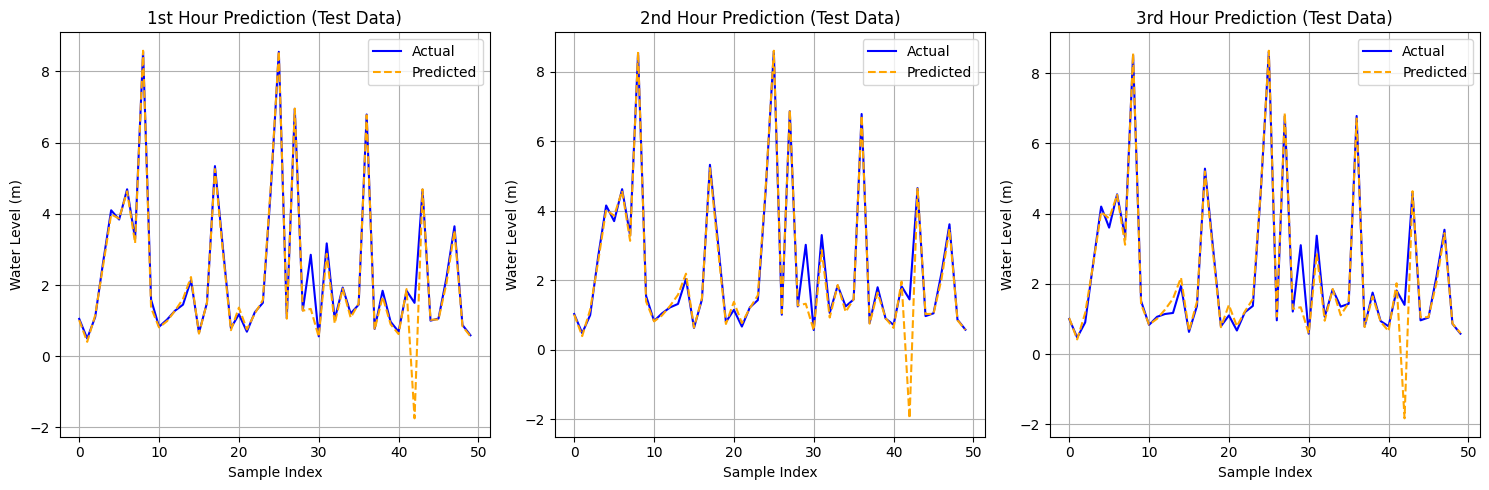

In [76]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = "F:/FYP project/FYP(Flood)/Real Data/Flood_fyp_data.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Handle NaN values using forward-fill
data.fillna(method='ffill', inplace=True)

# Drop 'Date' and 'Hour' columns if they exist
data = data.drop(columns=['Date', 'Hour'], errors='ignore')

# Define input features (X) and target values (y)
X = data[['Discharge Rate (cumecs)', 'Rainfall Data (mm)', 'Water Level (m)']].values
y = data[['Next 1 Hour Water Level (m)', 'Next 2 Hours Water Level (m)', 'Next 3 Hours Water Level (m)']].values

# Normalize the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Function to create time-step sequences
def create_time_steps_data(X, y, time_steps):
    """
    Converts 2D data into 3D format for LSTM (samples, time_steps, features).
    
    Args:
        X: Input features (2D array).
        y: Target values (2D array).
        time_steps: Number of time steps to include in each sample.
        
    Returns:
        X_new: 3D array for LSTM (samples, time_steps, features).
        y_new: Target values (aligned with time steps).
    """
    X_new, y_new = [], []
    
    for i in range(time_steps, len(X)):
        # Use the past `time_steps` rows as input
        X_new.append(X[i-time_steps:i, :])
        # Align the target with the last time step
        y_new.append(y[i])
    
    return np.array(X_new), np.array(y_new)

# Set number of time steps
time_steps = 3

# Convert data into time-step format
X_time_steps, y_time_steps = create_time_steps_data(X_scaled, y, time_steps)

# Split dataset into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X_time_steps, y_time_steps, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the LSTM model
model = Sequential()

# LSTM layers
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3))  # 3 outputs (1st, 2nd, 3rd hour predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on the test set
y_test_pred = model.predict(X_test)

# Function to calculate accuracy as a percentage
def calculate_accuracy(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE in percentage
    accuracy = 100 - mape  # Accuracy in percentage
    return accuracy

# Calculate accuracy and MAE for each hour
accuracy_1st_hour = calculate_accuracy(y_test[:, 0], y_test_pred[:, 0])
mae_1st_hour = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])

accuracy_2nd_hour = calculate_accuracy(y_test[:, 1], y_test_pred[:, 1])
mae_2nd_hour = mean_absolute_error(y_test[:, 1], y_test_pred[:, 1])

accuracy_3rd_hour = calculate_accuracy(y_test[:, 2], y_test_pred[:, 2])
mae_3rd_hour = mean_absolute_error(y_test[:, 2], y_test_pred[:, 2])

# Print accuracies and MAE
print("\nTesting Results:")
print(f"1st Hour Prediction Accuracy: {accuracy_1st_hour:.2f}%, MAE: {mae_1st_hour:.4f}")
print(f"2nd Hour Prediction Accuracy: {accuracy_2nd_hour:.2f}%, MAE: {mae_2nd_hour:.4f}")
print(f"3rd Hour Prediction Accuracy: {accuracy_3rd_hour:.2f}%, MAE: {mae_3rd_hour:.4f}")

# Visualize true vs predicted values for all 3 targets
plt.figure(figsize=(15, 5))
for i, target in enumerate(['1st Hour', '2nd Hour', '3rd Hour']):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test[:50, i], label='Actual', color='blue')
    plt.plot(y_test_pred[:50, i], label='Predicted', color='orange', linestyle='--')
    plt.title(f'{target} Prediction (Test Data)')
    plt.xlabel('Sample Index')
    plt.ylabel('Water Level (m)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()
